In [52]:
from torchvision import transforms, datasets
from IPython.display import display
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import os
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import einops
from torchvision.utils import save_image,make_grid
import glob
from torch.optim import Adam

In [53]:
BATCH_SIZE = 128
IMG_SIZE = 28
CHANNEL = 1
EPOCH = 130
SIZE = 20
lr = 0.0001
MODEL_DIR = 'model_weight'
root_train = 'cartoonset10k'

save_dir = os.path.join(MODEL_DIR)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [54]:
print(torch.__version__)
print(torch.version.cuda)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

2.3.0
None


In [55]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [56]:
def show_tensor_image(image,save,idx=0):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[idx, :, :, :]
    if save == False:
        #print(str)
        #image = torch.clamp(image, min=-1, max=1)  # clamp [-1, 1]
        plt.imshow(reverse_transforms(image), cmap="gray")
        return image
    else:
        return image
    #plt.show()

def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch
        num_images = 6
        idx = 0
        plt.figure(figsize=(15,15))
        plt.axis('off')
        for percent in [0.0 ,0.2,0.4, 0.6, 0.8, 1]:
            plt.subplot(1, num_images + 1, idx + 1)
            if percent == 0.0:
                show_tensor_image(imgs,False)
            else:
                show_tensor_image(ddpm(imgs.to(device),
                    [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]).detach().cpu(),False)
            idx += 1
        break
    plt.show()

def generate_new_images(ddpm, n_samples=16, device=None, c=1, h=28, w=28,process=False):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    images = []
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        if process == True:
            tmp = torch.zeros((n_samples, c, h, w), dtype=torch.float32).to(device)
            images = tmp.detach().cpu()

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)
        steps = int(ddpm.n_steps/6)
        #print('steps:', steps)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
            if process and (idx ==0 or (idx+1) % steps==0) :
                images=torch.cat((images,x.detach().cpu()),0)
                #images.append(x)
        if process:
            return images
    #print(x.shape)
    return x

In [57]:
train_data = []

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)
])
directory = "cartoonset10k"

for im_path in glob.glob(os.path.join(directory, '*.png')):
    train_data.append(transform(Image.open(im_path)))
print(len(train_data))



10000


In [58]:
data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )

In [59]:
print(train_data[0].shape)

torch.Size([1, 28, 28])


In [60]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [61]:
class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        if self.normalize:
            out = self.ln(x)
        else:
            out = x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [62]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, image_channels=1):
        super(UNet, self).__init__()
        down_channels = (image_channels,16, 32, 64)
        up_channels = (128 ,64, 32, 16)
        size = (28, 14, 7)
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, down_channels[0])
        self.b1 = self._make_conv(down_channels[0], down_channels[1] ,down_channels[1], size[0] )
        self.down1 = nn.Conv2d(down_channels[1], down_channels[1], 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, down_channels[1])
        self.b2 = self._make_conv(down_channels[1], down_channels[2] ,down_channels[2], size[1] )
        self.down2 = nn.Conv2d(down_channels[2], down_channels[2], 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, down_channels[2])
        self.b3 = self._make_conv(down_channels[2], down_channels[3] ,down_channels[3], size[2] )
        self.down3 = nn.Sequential(
            nn.Conv2d(down_channels[3], down_channels[3], 2, 1),
            nn.ReLU(),
            nn.Conv2d(down_channels[3], down_channels[3], 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, down_channels[3])
        self.b_mid = nn.Sequential(
            Block((down_channels[3], 3, 3), down_channels[3], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[3])
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, up_channels[0])
        self.b4 = self._make_conv(up_channels[0], up_channels[1] ,up_channels[2], size[2] )

        self.up2 = nn.ConvTranspose2d(up_channels[2], up_channels[2], 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, up_channels[1])
        self.b5 = self._make_conv(up_channels[1], up_channels[2] ,up_channels[3], size[1] )

        self.up3 = nn.ConvTranspose2d(up_channels[3], up_channels[3], 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, up_channels[2])
        self.b_out = self._make_conv(up_channels[2], up_channels[3] ,up_channels[3], size[0] )
        self.conv_out = nn.Conv2d(up_channels[3], 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 16, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 32, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 64, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 64, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 128, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 32, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 64, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 16, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 32, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        out = self.conv_out(out)
        #print('Network:',out.shape)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def _make_conv(self, in_c, mid_c, out_c, size, normalize=True ):
        return nn.Sequential(
            Block((in_c, size, size), in_c, mid_c),
            Block((mid_c, size, size), mid_c, out_c),
            Block((out_c, size, size), out_c, out_c,normalize=normalize)
        )
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device).to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  1213704


DDPM(
  (network): UNet(
    (time_embed): Embedding(1000, 100)
    (te1): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (b1): Sequential(
      (0): Block(
        (ln): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

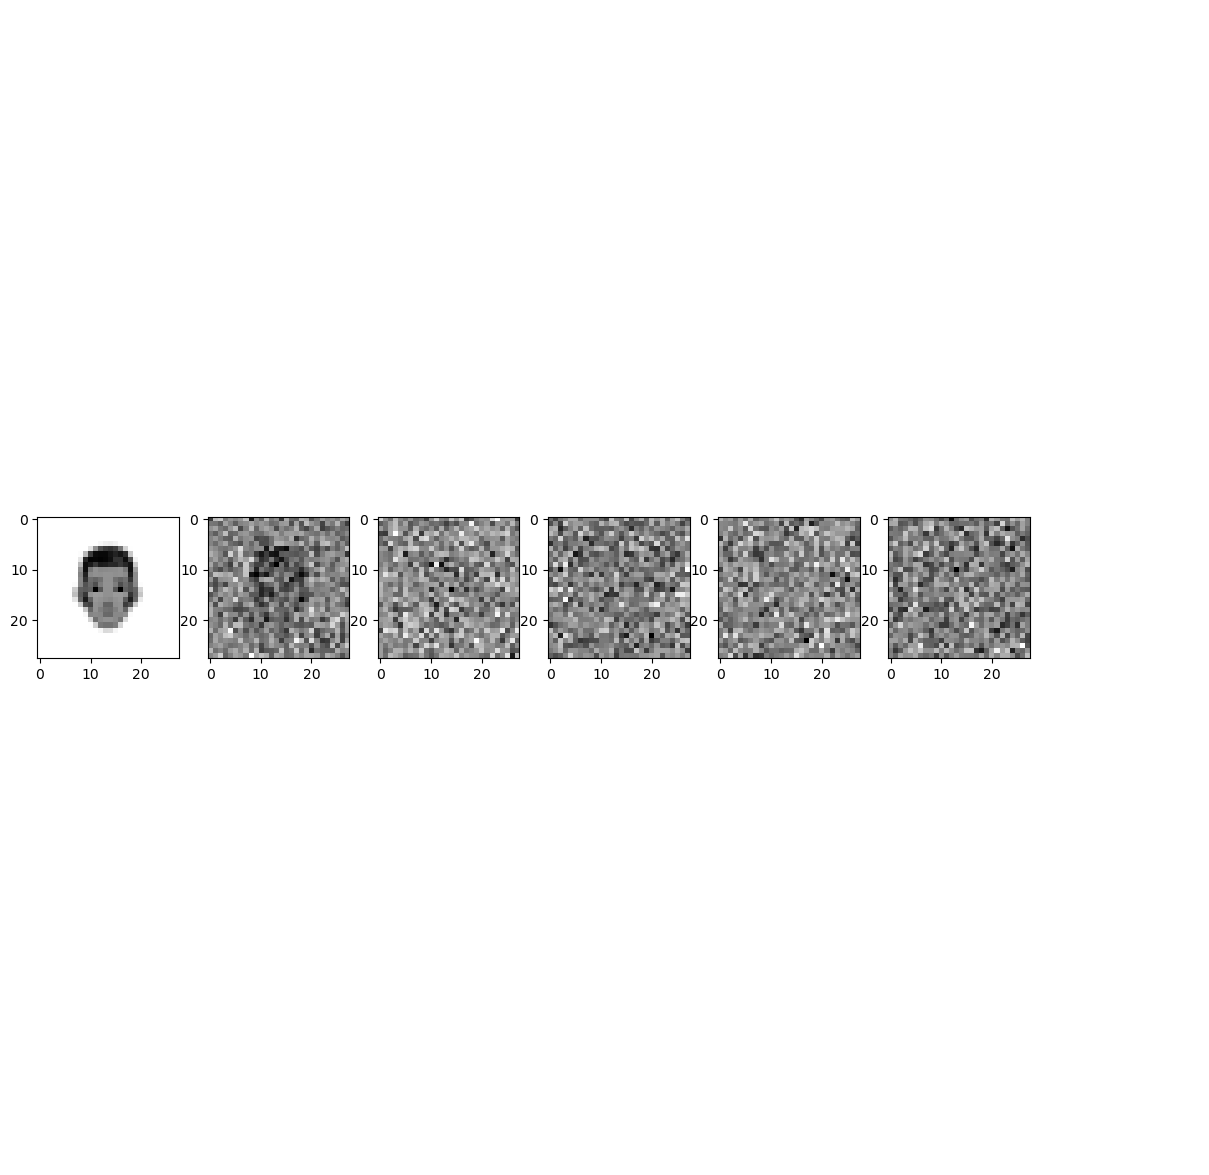

In [63]:
# Optionally, show the diffusion (forward) process
#for step, batch in enumerate(data_loader):
show_forward(model, data_loader, device)

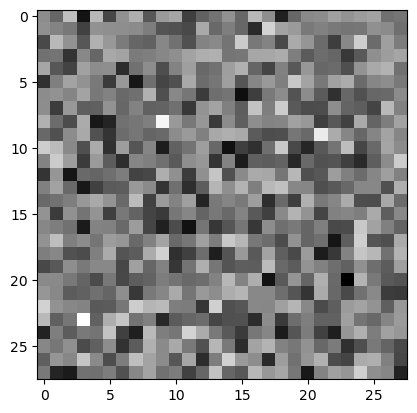

In [64]:
generated = generate_new_images(model,n_samples=1)
img = show_tensor_image(generated.detach().cpu(),False)

Epoch 0 | step 077 Loss: 0.650078296661377 


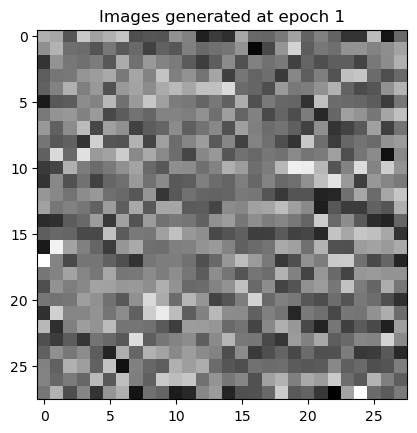

Loss at epoch 1: 0.864 --> Best model ever (stored)
Loss at epoch 2: 0.425 --> Best model ever (stored)
Loss at epoch 3: 0.188 --> Best model ever (stored)
Loss at epoch 4: 0.129 --> Best model ever (stored)
Loss at epoch 5: 0.095 --> Best model ever (stored)
Epoch 5 | step 077 Loss: 0.07605889439582825 


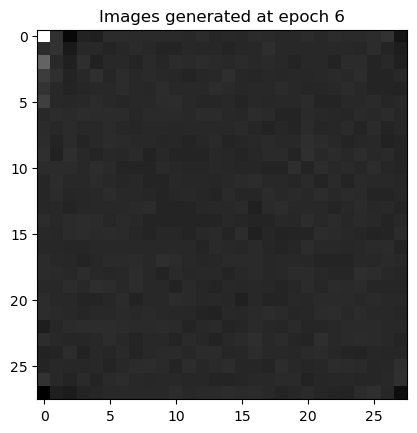

Loss at epoch 6: 0.075 --> Best model ever (stored)
Loss at epoch 7: 0.064 --> Best model ever (stored)
Loss at epoch 8: 0.057 --> Best model ever (stored)
Loss at epoch 9: 0.054 --> Best model ever (stored)
Loss at epoch 10: 0.050 --> Best model ever (stored)
Epoch 10 | step 077 Loss: 0.0431160107254982 


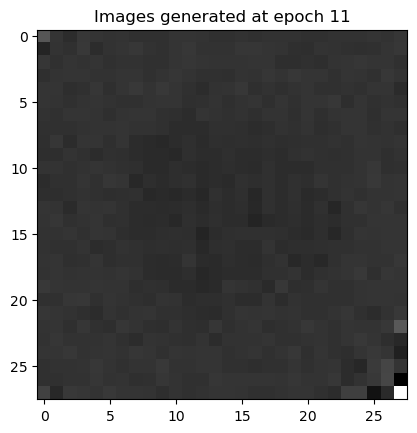

Loss at epoch 11: 0.048 --> Best model ever (stored)
Loss at epoch 12: 0.045 --> Best model ever (stored)
Loss at epoch 13: 0.044 --> Best model ever (stored)
Loss at epoch 14: 0.042 --> Best model ever (stored)
Loss at epoch 15: 0.039 --> Best model ever (stored)
Epoch 15 | step 077 Loss: 0.03591682389378548 


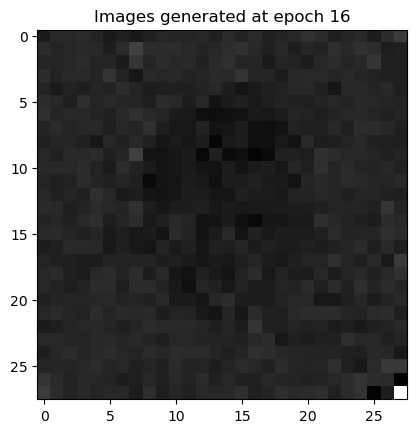

Loss at epoch 16: 0.039
Loss at epoch 17: 0.038 --> Best model ever (stored)
Loss at epoch 18: 0.037 --> Best model ever (stored)
Loss at epoch 19: 0.036 --> Best model ever (stored)
Loss at epoch 20: 0.036 --> Best model ever (stored)
Epoch 20 | step 077 Loss: 0.0349855050444603 


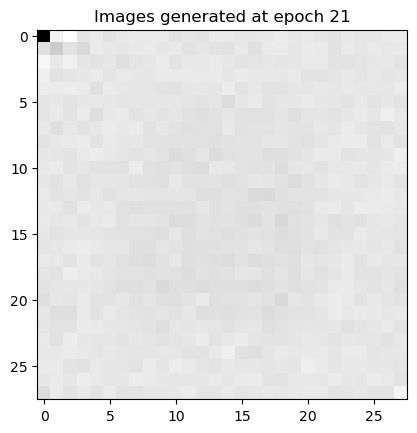

Loss at epoch 21: 0.034 --> Best model ever (stored)
Loss at epoch 22: 0.035
Loss at epoch 23: 0.034
Loss at epoch 24: 0.035
Loss at epoch 25: 0.033 --> Best model ever (stored)
Epoch 25 | step 077 Loss: 0.0455288290977478 


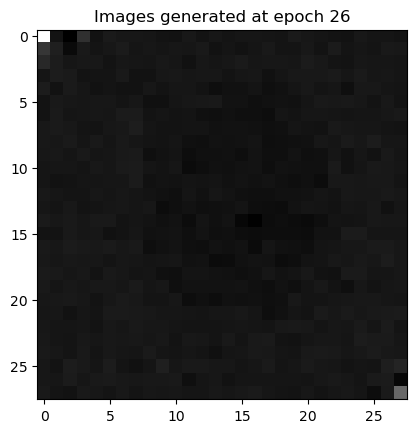

Loss at epoch 26: 0.032 --> Best model ever (stored)
Loss at epoch 27: 0.033
Loss at epoch 28: 0.031 --> Best model ever (stored)
Loss at epoch 29: 0.031 --> Best model ever (stored)
Loss at epoch 30: 0.031
Epoch 30 | step 077 Loss: 0.026718148961663246 


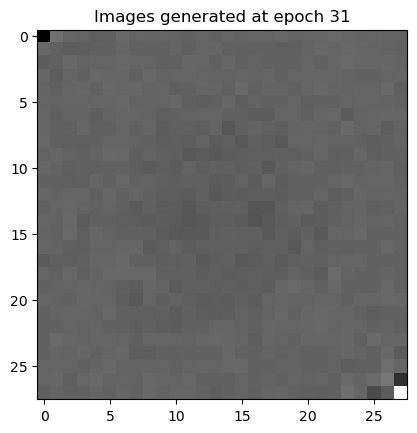

Loss at epoch 31: 0.031
Loss at epoch 32: 0.031
Loss at epoch 33: 0.030 --> Best model ever (stored)
Loss at epoch 34: 0.030
Loss at epoch 35: 0.030 --> Best model ever (stored)
Epoch 35 | step 077 Loss: 0.025286557152867317 


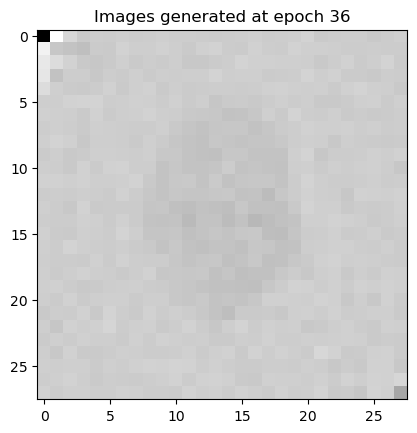

Loss at epoch 36: 0.028 --> Best model ever (stored)
Loss at epoch 37: 0.029
Loss at epoch 38: 0.028
Loss at epoch 39: 0.028
Loss at epoch 40: 0.028 --> Best model ever (stored)
Epoch 40 | step 077 Loss: 0.01801043003797531 


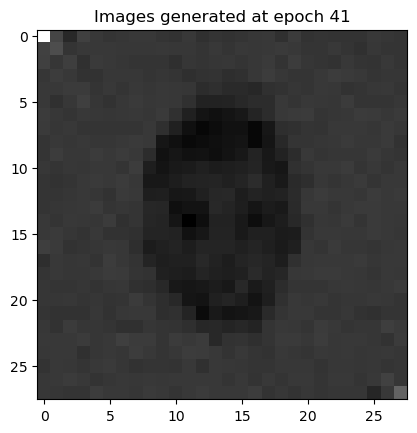

Loss at epoch 41: 0.028
Loss at epoch 42: 0.027 --> Best model ever (stored)
Loss at epoch 43: 0.028
Loss at epoch 44: 0.027 --> Best model ever (stored)
Loss at epoch 45: 0.026 --> Best model ever (stored)
Epoch 45 | step 077 Loss: 0.021855957806110382 


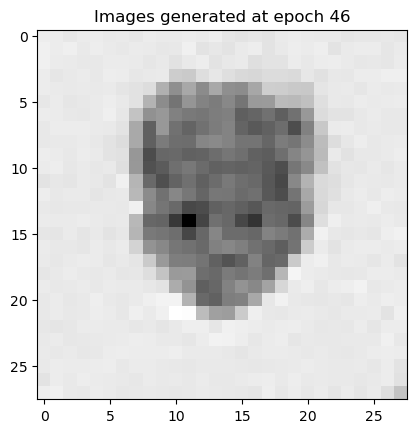

Loss at epoch 46: 0.027
Loss at epoch 47: 0.026
Loss at epoch 48: 0.026 --> Best model ever (stored)
Loss at epoch 49: 0.025 --> Best model ever (stored)
Loss at epoch 50: 0.026
Epoch 50 | step 077 Loss: 0.03581029176712036 


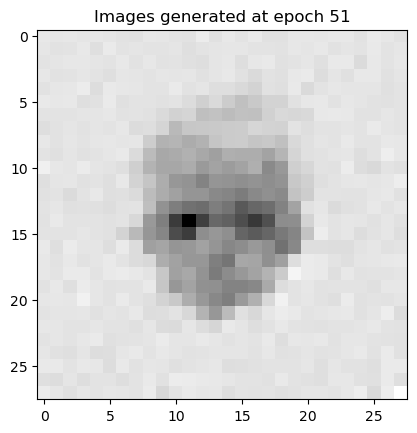

Loss at epoch 51: 0.026
Loss at epoch 52: 0.026
Loss at epoch 53: 0.025 --> Best model ever (stored)
Loss at epoch 54: 0.025 --> Best model ever (stored)
Loss at epoch 55: 0.025 --> Best model ever (stored)
Epoch 55 | step 077 Loss: 0.019639277830719948 


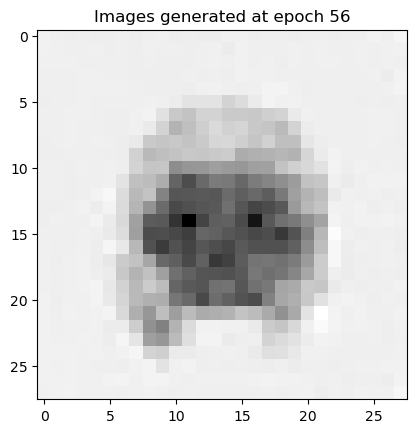

Loss at epoch 56: 0.025
Loss at epoch 57: 0.025
Loss at epoch 58: 0.025 --> Best model ever (stored)
Loss at epoch 59: 0.024 --> Best model ever (stored)
Loss at epoch 60: 0.025
Epoch 60 | step 077 Loss: 0.019900139421224594 


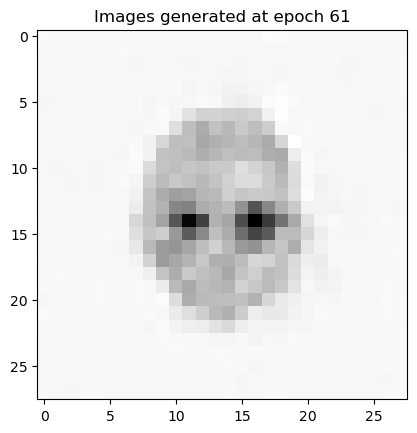

Loss at epoch 61: 0.024 --> Best model ever (stored)
Loss at epoch 62: 0.025
Loss at epoch 63: 0.025
Loss at epoch 64: 0.025
Loss at epoch 65: 0.025
Epoch 65 | step 077 Loss: 0.025880010798573494 


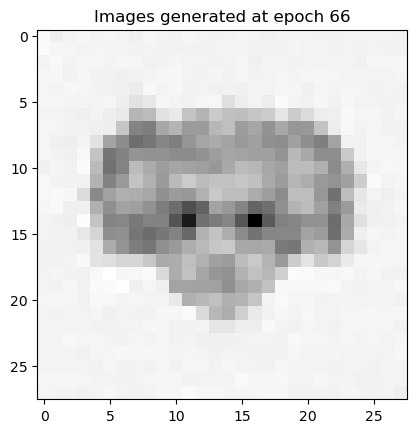

Loss at epoch 66: 0.023 --> Best model ever (stored)
Loss at epoch 67: 0.024
Loss at epoch 68: 0.023 --> Best model ever (stored)
Loss at epoch 69: 0.024
Loss at epoch 70: 0.024
Epoch 70 | step 077 Loss: 0.024308472871780396 


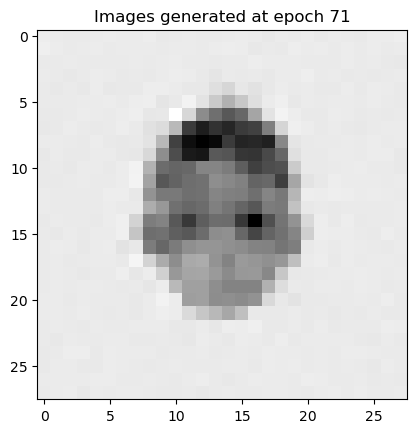

Loss at epoch 71: 0.024
Loss at epoch 72: 0.024
Loss at epoch 73: 0.023
Loss at epoch 74: 0.023
Loss at epoch 75: 0.023
Epoch 75 | step 077 Loss: 0.015526440925896168 


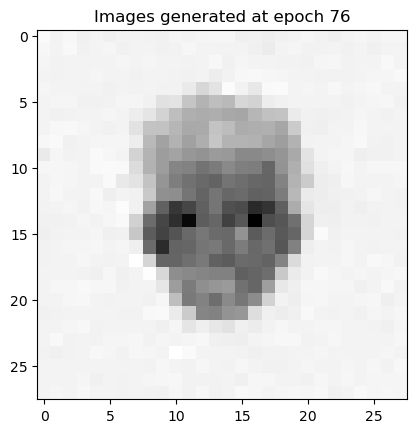

Loss at epoch 76: 0.023 --> Best model ever (stored)
Loss at epoch 77: 0.024
Loss at epoch 78: 0.023
Loss at epoch 79: 0.022 --> Best model ever (stored)
Loss at epoch 80: 0.023
Epoch 80 | step 077 Loss: 0.024533968418836594 


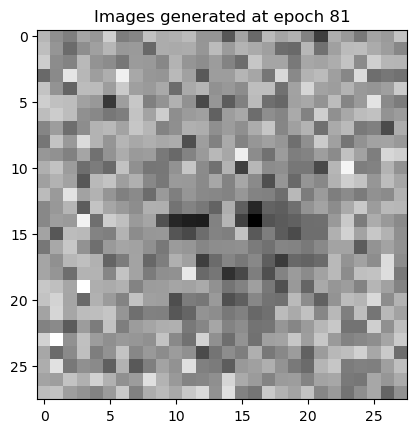

Loss at epoch 81: 0.023
Loss at epoch 82: 0.023
Loss at epoch 83: 0.023
Loss at epoch 84: 0.022 --> Best model ever (stored)
Loss at epoch 85: 0.022
Epoch 85 | step 077 Loss: 0.016973014920949936 


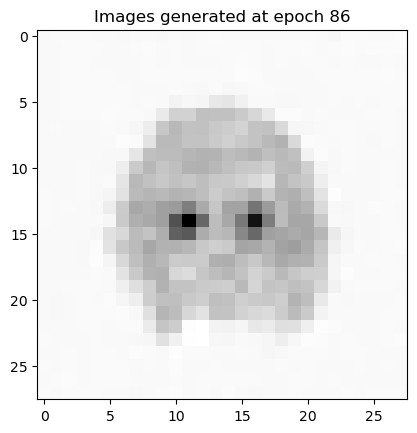

Loss at epoch 86: 0.022 --> Best model ever (stored)
Loss at epoch 87: 0.023
Loss at epoch 88: 0.022
Loss at epoch 89: 0.022
Loss at epoch 90: 0.022
Epoch 90 | step 077 Loss: 0.023146960884332657 


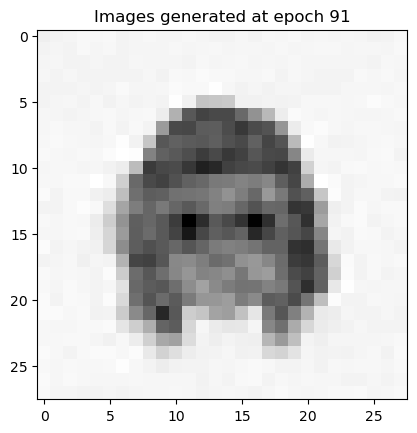

Loss at epoch 91: 0.023
Loss at epoch 92: 0.022
Loss at epoch 93: 0.021 --> Best model ever (stored)
Loss at epoch 94: 0.022
Loss at epoch 95: 0.022
Epoch 95 | step 077 Loss: 0.019723370671272278 


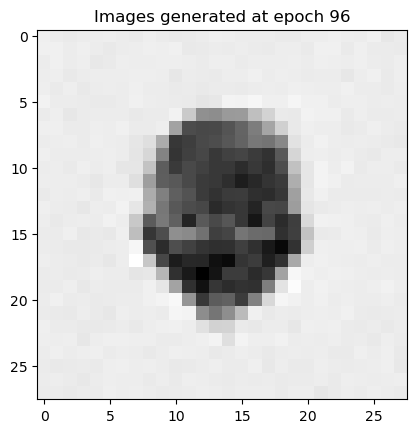

Loss at epoch 96: 0.022
Loss at epoch 97: 0.022
Loss at epoch 98: 0.021
Loss at epoch 99: 0.022
Loss at epoch 100: 0.022
Epoch 100 | step 077 Loss: 0.022627120837569237 


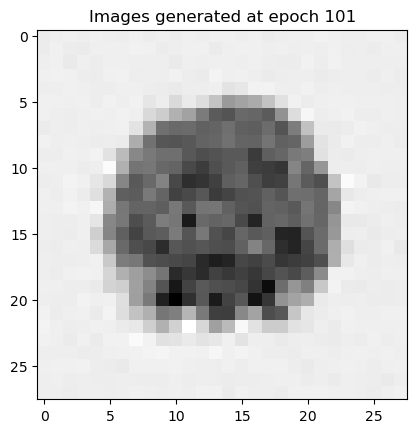

Loss at epoch 101: 0.022
Loss at epoch 102: 0.021 --> Best model ever (stored)
Loss at epoch 103: 0.022
Loss at epoch 104: 0.022
Loss at epoch 105: 0.022
Epoch 105 | step 077 Loss: 0.028932634741067886 


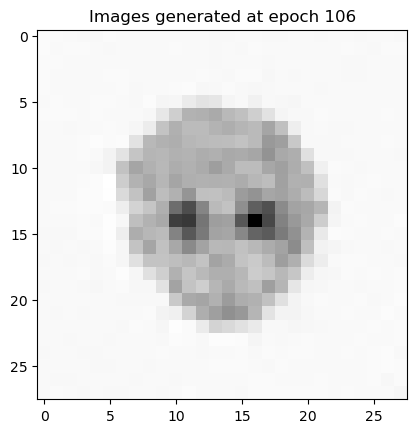

Loss at epoch 106: 0.022
Loss at epoch 107: 0.022
Loss at epoch 108: 0.022
Loss at epoch 109: 0.021 --> Best model ever (stored)
Loss at epoch 110: 0.021
Epoch 110 | step 077 Loss: 0.024340130388736725 


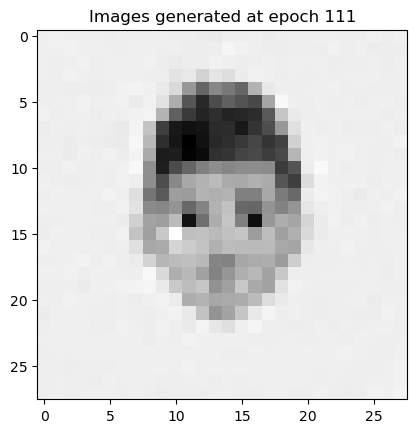

Loss at epoch 111: 0.021 --> Best model ever (stored)
Loss at epoch 112: 0.022
Loss at epoch 113: 0.022
Loss at epoch 114: 0.020 --> Best model ever (stored)
Loss at epoch 115: 0.021
Epoch 115 | step 077 Loss: 0.023569177836179733 


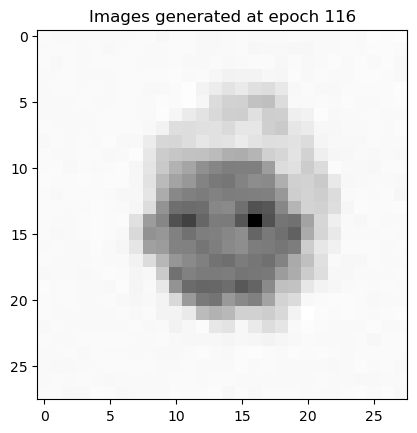

Loss at epoch 116: 0.020
Loss at epoch 117: 0.021
Loss at epoch 118: 0.022
Loss at epoch 119: 0.021
Loss at epoch 120: 0.021
Epoch 120 | step 077 Loss: 0.018823549151420593 


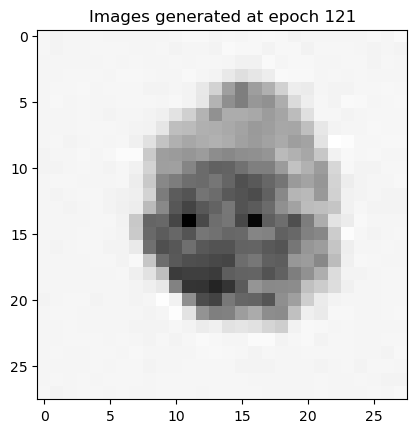

Loss at epoch 121: 0.021
Loss at epoch 122: 0.021
Loss at epoch 123: 0.021
Loss at epoch 124: 0.020
Loss at epoch 125: 0.021
Epoch 125 | step 077 Loss: 0.02871933951973915 


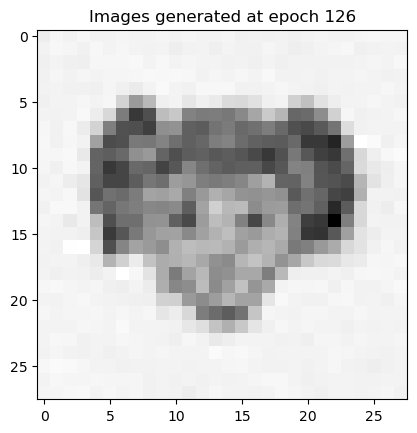

Loss at epoch 126: 0.021
Loss at epoch 127: 0.021
Loss at epoch 128: 0.021
Loss at epoch 129: 0.021
Loss at epoch 130: 0.021


In [65]:
train_hist = {}
train_hist['loss'] = []
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()
best_loss = float("inf")
n_steps = model.n_steps
epochs = EPOCH # Try more!
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance
for epoch in range(epochs):
    data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )
    optimizer.param_groups[0]['lr'] = lr*(1-epoch/epochs)
    epoch_loss = 0.0
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()

      #t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      #print('batch:', batch.shape)
      x = batch.to(device)
      n = len(x)
      # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
      eta = torch.randn_like(x).to(device)
      t = torch.randint(0, n_steps, (n,)).to(device)
      # Computing the noisy image based on x0 and the time-step (forward process)
      noisy_imgs = model(x, t, eta)
      # Getting model estimation of noise based on the images and the time-step
      eta_theta = model.backward(noisy_imgs, t.reshape(n, -1))
      #print(eta_theta.shape,eta.shape)
      loss = mse(eta_theta, eta)
      train_hist['loss'].append(loss.item())
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * len(x) / len(data_loader.dataset)
    if epoch % 5 == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      img=generate_new_images(model,n_samples=4, device=device)
      #, f"Images generated at epoch {epoch + 1}"
      show_tensor_image(img.detach().cpu(),False)
      plt.title(f"Images generated at epoch {epoch + 1}")
      plt.show()
    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'testing.pt'))
        log_string += " --> Best model ever (stored)"
    print(log_string)

In [66]:
torch.save(model.state_dict(), os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt'))

8


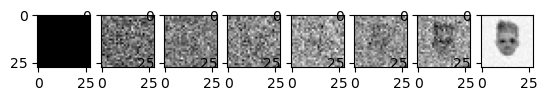

In [67]:
# Denoising
model.load_state_dict(torch.load(os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt')))
imgs=generate_new_images(model,n_samples=1, device=device,process=True)
      #, f"Images generated at epoch {epoch + 1}"
print(len(imgs))
for idx,img in enumerate(imgs):
      plt.subplot(1, 7 + 1, idx + 1)
      show_tensor_image(img.detach().cpu(),False)

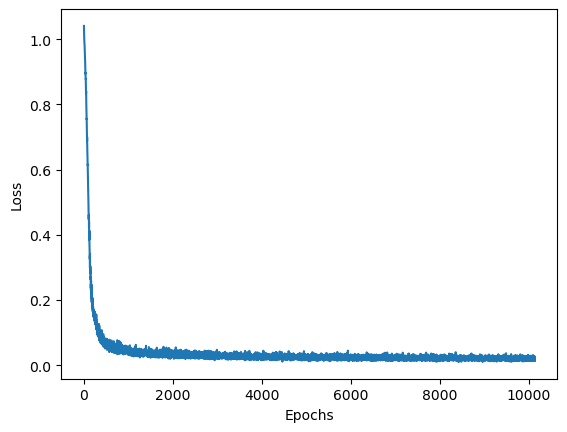

In [68]:
fig = plt.figure()
plt.plot(train_hist['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Saving 00001.png
Saving 00002.png
Saving 00003.png
Saving 00004.png
Saving 00005.png
Saving 00006.png
Saving 00007.png
Saving 00008.png
Saving 00009.png
Saving 00010.png


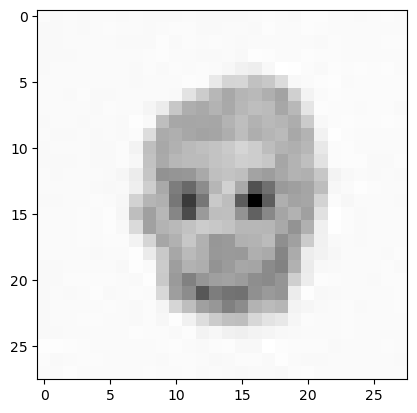

In [69]:
@torch.no_grad()
def plot_result_image():
    # Sample noise
    num_images = 10
    os.makedirs('./images', exist_ok=True)
    for j in range(num_images):
        path = os.path.join(f'./images/{j+1:05d}.png')
        image = generate_new_images(model,n_samples=1, device=device)
        img = show_tensor_image(image.detach().cpu(),False)
        print(f'Saving {j+1:05d}.png')
        save_image(img,path,normalize=True)

plot_result_image()